In [1]:
# importing laibrary
import numpy as np
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# Enable GPU if available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU')
else:
    print('CUDA is available! Training on GPU')

CUDA is available! Training on GPU


In [3]:
torch.cuda.is_available()

True

In [4]:
# Data Augmentation
train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomRotation(20),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])


In [5]:
# Data Preprocessing
train_data = datasets.ImageFolder('dataset/train/', transform=train_transforms)
valid_data = datasets.ImageFolder('dataset/valid/', transform=valid_transforms)
test_data = datasets.ImageFolder('dataset/test/', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size= 128, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size= 128)
testloader = torch.utils.data.DataLoader(test_data, batch_size= 128)


In [6]:
print(valid_data.class_to_idx)

{'01.G-pics': 0, '02.Mc-pics': 1, '03.Mu-pics': 2, '04.Vl-pics': 3, '05.Vm-pics': 4}


In [7]:
x, y = next(iter(trainloader))

In [9]:
x.shape

torch.Size([128, 3, 224, 224])

In [9]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [9]:
y.shape

torch.Size([128])

In [11]:
# importing the model densenet121
# Use GPU if it is availabel


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.densenet121(pretrained=True)

# Freeze the parameters except last fully connected layer so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Now unfreeze the fully connected layer
for param in list(model.parameters())[-15:]:
    param.requires_grad = True
    
    
# Add custom layer at end of the model
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.BatchNorm1d(512),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(512, 8))
# Defining the loss function
criterion = nn.CrossEntropyLoss()
# Defining the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay = 0.0001)
if train_on_gpu:
    model.cuda()

# Frist time training :
#### Learning rate is set 0.001 , batch size = 128 and run for 22 epochs, weight_decay = 0.0001 , the best result is :
Epoch :9/100 	Training Loss : 0.028698 	Validation Loss : 0.072107 	Validation Accuracy : 0.974649                         
Test Loss : 0.135589 	Test Accuracy : 0.950160 

In [13]:
# Defining the training process
epochs = 100
valid_loss_min = np.Inf
train_his, valid_his = [], []
model.train()
for epoch in range(epochs):
    training_loss = 0
    valid_loss = 0
    for inputs, labels in trainloader:
        torch.cuda.empty_cache()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        
        optimizer.step()
        training_loss += loss.item()
        
    valid_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in validloader:
            torch.cuda.empty_cache()
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            valid_loss += loss.item()
            
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
    
    training_loss = training_loss / len(trainloader)
    valid_loss = valid_loss / len(validloader)
    valid_accuracy = valid_accuracy / len(validloader)
    train_his.append(training_loss)
    valid_his.append(valid_loss)
    
    print('Epoch :{}/{} \tTraining Loss : {:.6f} \tValidation Loss : {:.6f} '
          '\tValidation Accuracy : {:.6f}'.format(epoch+1, epochs, training_loss, valid_loss, valid_accuracy))
    
    # Save the model if the validation loss is decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ............'.format(valid_loss_min, valid_loss))
    
        torch.save(model, 'liveliness_detection_2.pt')
        valid_loss_min = valid_loss

Epoch :1/100 	Training Loss : 0.220814 	Validation Loss : 0.165438 	Validation Accuracy : 0.935906
Validation loss decreased (inf --> 0.165438). Saving model ............
Epoch :2/100 	Training Loss : 0.096786 	Validation Loss : 0.115905 	Validation Accuracy : 0.961416
Validation loss decreased (0.165438 --> 0.115905). Saving model ............
Epoch :3/100 	Training Loss : 0.058397 	Validation Loss : 0.130942 	Validation Accuracy : 0.950893
Epoch :4/100 	Training Loss : 0.048639 	Validation Loss : 0.112832 	Validation Accuracy : 0.956792
Validation loss decreased (0.115905 --> 0.112832). Saving model ............
Epoch :5/100 	Training Loss : 0.047440 	Validation Loss : 0.112939 	Validation Accuracy : 0.955995
Epoch :6/100 	Training Loss : 0.043367 	Validation Loss : 0.084671 	Validation Accuracy : 0.969866
Validation loss decreased (0.112832 --> 0.084671). Saving model ............
Epoch :7/100 	Training Loss : 0.039308 	Validation Loss : 0.135896 	Validation Accuracy : 0.948820
Epoc

KeyboardInterrupt: 

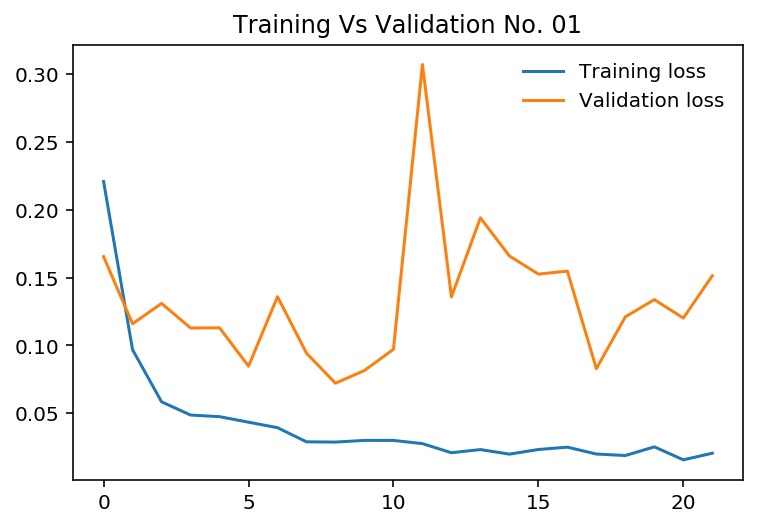

In [14]:
plt.plot(train_his, label='Training loss')
plt.plot(valid_his, label='Validation loss')
plt.title('Training Vs Validation No. 01')
plt.legend(frameon=False)
plt.savefig('Train_vs_Valid_1.png')

In [14]:
test_his = []
test_accuracy = 0
test_loss = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the loss function
criterion = nn.CrossEntropyLoss()
# Defining the optimizer
#optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay = 0.0001)
if train_on_gpu:
    model.cuda()
    

model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        test_loss += loss.item()
            
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    test_loss = test_loss / len(testloader)
    test_accuracy = test_accuracy / len(testloader)
    test_his.append(test_loss)


print('Test Loss : {:.6f} \tTest Accuracy : {:.6f} '.format(test_loss, test_accuracy))

Test Loss : 0.154369 	Test Accuracy : 0.948772 


# Training for 2nd time
#### 2nd time training with 0.001 learning rate

In [10]:
model = torch.load('liveliness_detection_2.pt')
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

# List of training after 1st time :



In [24]:
# Use GPU if it is availabel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Freeze the parameters except last fully connected layer so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Now unfreeze the fully connected layer
for param in list(model.parameters())[-15:]:
    param.requires_grad = True
    
    
# Defining the loss function
criterion = nn.CrossEntropyLoss()
# Defining the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0000001, weight_decay=0.001)
if train_on_gpu:
    model.cuda()

In [26]:
# Defining the training process
epochs = 10
valid_loss_min = 0.072107
train_his, valid_his = [], []
model.train()
for epoch in range(epochs):
    training_loss = 0
    valid_loss = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        
        optimizer.step()
        training_loss += loss.item()
        
    valid_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            valid_loss += loss.item()
            
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
    
    training_loss = training_loss / len(trainloader)
    valid_loss = valid_loss / len(validloader)
    valid_accuracy = valid_accuracy / len(validloader)
    train_his.append(training_loss)
    valid_his.append(valid_loss)
    
    print('Epoch :{}/{} \tTraining Loss : {:.6f} \tValidation Loss : {:.6f} '
          '\tValidation Accuracy : {:.6f}'.format(epoch+1, epochs, training_loss, valid_loss, valid_accuracy))
    
    # Save the model if the validation loss is decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ............'.format(valid_loss_min, valid_loss))
    
        torch.save(model, 'liveliness_detection_2.pt')
        valid_loss_min = valid_loss

Epoch :1/10 	Training Loss : 0.116469 	Validation Loss : 0.161057 	Validation Accuracy : 0.959184
Epoch :2/10 	Training Loss : 0.082555 	Validation Loss : 0.157688 	Validation Accuracy : 0.959024
Epoch :3/10 	Training Loss : 0.079479 	Validation Loss : 0.155696 	Validation Accuracy : 0.958865
Epoch :4/10 	Training Loss : 0.077167 	Validation Loss : 0.154272 	Validation Accuracy : 0.957908
Epoch :5/10 	Training Loss : 0.071931 	Validation Loss : 0.153088 	Validation Accuracy : 0.956314
Epoch :6/10 	Training Loss : 0.072231 	Validation Loss : 0.151900 	Validation Accuracy : 0.956314
Epoch :7/10 	Training Loss : 0.068672 	Validation Loss : 0.150801 	Validation Accuracy : 0.955995
Epoch :8/10 	Training Loss : 0.067442 	Validation Loss : 0.149450 	Validation Accuracy : 0.955995
Epoch :9/10 	Training Loss : 0.067626 	Validation Loss : 0.148248 	Validation Accuracy : 0.955995
Epoch :10/10 	Training Loss : 0.066681 	Validation Loss : 0.147370 	Validation Accuracy : 0.955995


In [ ]:
for i in range(len())

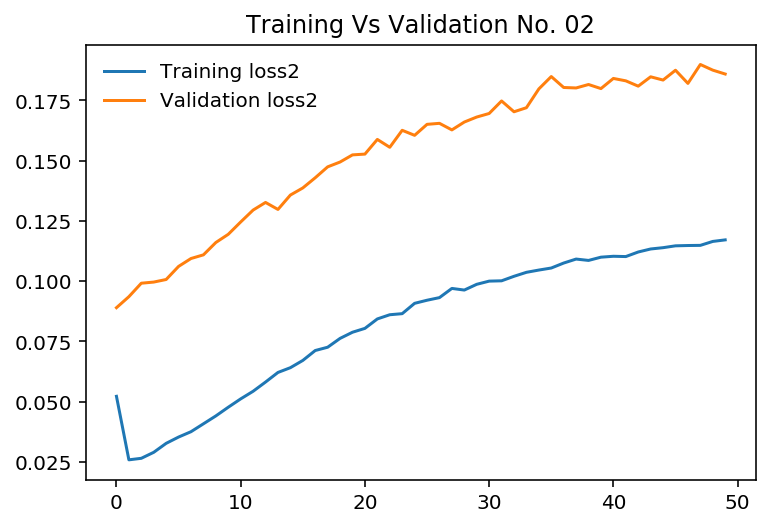

In [23]:
# Plot the train and validation loss
plt.plot(train_his, label='Training loss2')
plt.plot(valid_his, label='Validation loss2')
plt.title('Training Vs Validation No. 02')
plt.legend(frameon=False)
plt.savefig('liveliness_train_vs_valid_2.png')

In [11]:
# Test the 2nd time pretrained model
test_accuracy = 0
test_loss = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        test_loss += loss.item()
            
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    test_loss = test_loss / len(testloader)
    test_accuracy = test_accuracy / len(testloader)


print('Test Loss : {:.6f} \tTest Accuracy : {:.6f} '.format(test_loss, test_accuracy))

Test Loss : 0.123067 	Test Accuracy : 0.954019 


In [15]:
type(testloader.shape)

AttributeError: 'DataLoader' object has no attribute 'shape'

Epoch :1/10 	Training Loss : 0.050539 	Validation Loss : 0.085357 	Validation Accuracy : 0.969866
Epoch :2/10 	Training Loss : 0.023249 	Validation Loss : 0.081802 	Validation Accuracy : 0.972258
Validation loss decreased (0.084671 --> 0.081802). Saving model ............
Epoch :3/10 	Training Loss : 0.020327 	Validation Loss : 0.081098 	Validation Accuracy : 0.970504
Validation loss decreased (0.081802 --> 0.081098). Saving model ............
Epoch :4/10 	Training Loss : 0.019229 	Validation Loss : 0.084505 	Validation Accuracy : 0.970026
Epoch :5/10 	Training Loss : 0.017963 	Validation Loss : 0.080951 	Validation Accuracy : 0.970823
Validation loss decreased (0.081098 --> 0.080951). Saving model ............
Epoch :6/10 	Training Loss : 0.016547 	Validation Loss : 0.089997 	Validation Accuracy : 0.967156
Epoch :7/10 	Training Loss : 0.015469 	Validation Loss : 0.080893 	Validation Accuracy : 0.971460
Validation loss decreased (0.080951 --> 0.080893). Saving model ............
Epoch :8/10 	Training Loss : 0.017608 	Validation Loss : 0.085791 	Validation Accuracy : 0.969547
Epoch :9/10 	Training Loss : 0.015813 	Validation Loss : 0.077752 	Validation Accuracy : 0.971779
Validation loss decreased (0.080893 --> 0.077752). Saving model ............
Epoch :10/10 	Training Loss : 0.015139 	Validation Loss : 0.074786 	Validation Accuracy : 0.972258
Validation loss decreased (0.077752 --> 0.074786). Saving model ............

In [10]:
model = torch.load('liveliness_detection_3.pt')
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [10]:
# Defining the training process
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
# Defining the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001, weight_decay = 0.0001)
if train_on_gpu:
    model.cuda()

epochs = 20
valid_loss_min = 0.074786
train_his, valid_his = [], []
model.train()
for epoch in range(epochs):
    training_loss = 0
    valid_loss = 0
    for inputs, labels in trainloader:
        torch.cuda.empty_cache()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        
        optimizer.step()
        training_loss += loss.item()
        
    valid_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in validloader:
            torch.cuda.empty_cache()
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            valid_loss += loss.item()
            
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
    
    training_loss = training_loss / len(trainloader)
    valid_loss = valid_loss / len(validloader)
    valid_accuracy = valid_accuracy / len(validloader)
    train_his.append(training_loss)
    valid_his.append(valid_loss)
    
    print('Epoch :{}/{} \tTraining Loss : {:.6f} \tValidation Loss : {:.6f} '
          '\tValidation Accuracy : {:.6f}'.format(epoch+1, epochs, training_loss, valid_loss, valid_accuracy))
    
    # Save the model if the validation loss is decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ............'.format(valid_loss_min, valid_loss))
    
        torch.save(model, 'liveliness_detection_3.pt')
        valid_loss_min = valid_loss

Epoch :1/20 	Training Loss : 0.028647 	Validation Loss : 0.075723 	Validation Accuracy : 0.971779
Epoch :2/20 	Training Loss : 0.010890 	Validation Loss : 0.088414 	Validation Accuracy : 0.964605
Epoch :3/20 	Training Loss : 0.011293 	Validation Loss : 0.079376 	Validation Accuracy : 0.969547
Epoch :4/20 	Training Loss : 0.011087 	Validation Loss : 0.087567 	Validation Accuracy : 0.966677
Epoch :5/20 	Training Loss : 0.009961 	Validation Loss : 0.063782 	Validation Accuracy : 0.976881
Validation loss decreased (0.074786 --> 0.063782). Saving model ............
Epoch :6/20 	Training Loss : 0.010547 	Validation Loss : 0.080664 	Validation Accuracy : 0.970185
Epoch :7/20 	Training Loss : 0.010624 	Validation Loss : 0.075277 	Validation Accuracy : 0.973693
Epoch :8/20 	Training Loss : 0.010298 	Validation Loss : 0.085051 	Validation Accuracy : 0.968750
Epoch :9/20 	Training Loss : 0.009731 	Validation Loss : 0.067373 	Validation Accuracy : 0.974968
Epoch :10/20 	Training Loss : 0.009380 	V

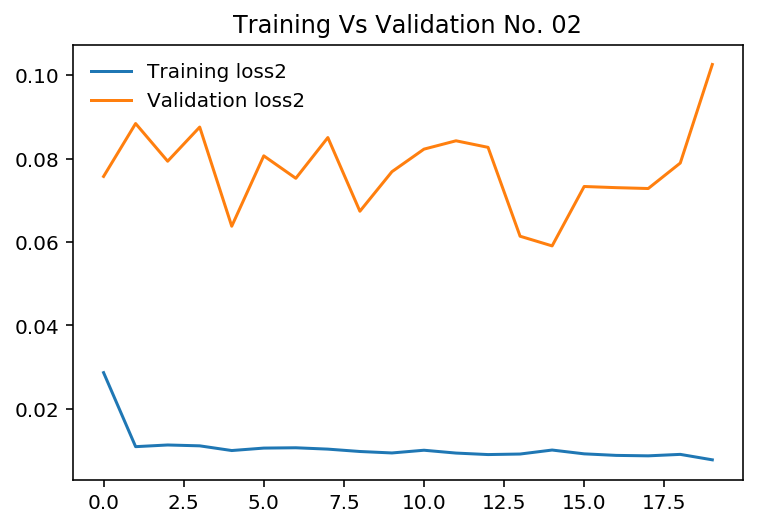

In [11]:
# Plot the train and validation loss
plt.plot(train_his, label='Training loss2')
plt.plot(valid_his, label='Validation loss2')
plt.title('Training Vs Validation No. 02')
plt.legend(frameon=False)
plt.savefig('liveliness_train_vs_valid_3.png')

In [12]:
nb_classes = 5

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[876.,   0.,   0.,   2.,  16.],
        [  0., 816.,  18.,   2.,   0.],
        [  0.,  13., 759.,   1.,   2.],
        [  1.,   1.,   0., 527.,  32.],
        [ 62.,   1.,   0.,  29., 792.]])


In [13]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.9799, 0.9761, 0.9794, 0.9394, 0.8959])
